In [2]:
import sys
sys.path.insert(0, "../pretrained_classifiers")
sys.path.insert(0, "../")

In [3]:
import os
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pylab
import numpy as np
import io
import torch.utils.model_zoo as model_zoo
import torch.onnx
from multiprocessing import Pool
from joblib import Parallel, delayed
import _thread as thread
from numba import njit, prange
import time
import itertools
import torch
from torch.autograd import Variable
from utee import selector
from boxprop import *
from boxprop_optimized import *
%load_ext autoreload
%autoreload 2

In [16]:
num_gpu = 1 if torch.cuda.is_available() else 0

# load the models
from dcgan import Discriminator, Generator

D = Discriminator(ngpu=1).eval()
G = Generator(ngpu=1).eval()

# load weights
D.load_state_dict(torch.load('weights/netD_epoch_199.pth',map_location=torch.device('cpu')))
G.load_state_dict(torch.load('weights/netG_epoch_199.pth',map_location=torch.device('cpu')))
if torch.cuda.is_available():
    D = D.cuda()
    G = G.cuda()

# generate some images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


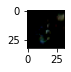

In [17]:
batch_size = 1
latent_size = 100

fixed_noise = torch.randn(batch_size, latent_size, 1, 1)
if torch.cuda.is_available():
    fixed_noise = fixed_noise.cuda()
fake_images = G(fixed_noise)


# z = torch.randn(batch_size, latent_size).cuda()
# z = Variable(z)
# fake_images = G(z)

fake_images_np = fake_images.cpu().detach().numpy()
fake_images_np = fake_images_np.reshape(fake_images_np.shape[0], 3, 32, 32)
fake_images_np = fake_images_np.transpose((0, 2, 3, 1))
R, C = 5, 5
for i in range(batch_size):
    plt.subplot(R, C, i + 1)
    plt.imshow(fake_images_np[i], interpolation='bilinear')
plt.show()

# run discriminator

In [18]:
outputs = D(fake_images)
print(outputs)

tensor([0.1157], grad_fn=<SqueezeBackward1>)


In [19]:
print(0)
tic = time.perf_counter()
a_o = Box_o(fixed_noise,fixed_noise,False)
a_o.convTranspose2d(weight=G.state_dict()['main.0.weight'], c_out=512, kernel_size=4, stride=1, padding=0, output_padding=0)
a_o.batchNorm2d(mean=G.state_dict()['main.1.running_mean'], var=G.state_dict()['main.1.running_var'], eps=1e-05, weight=G.state_dict()['main.1.weight'], bias=G.state_dict()['main.1.bias'])
a_o.relu()
print(time.perf_counter()-tic)
print(1)
tic = time.perf_counter()
a_o.convTranspose2d(weight=G.state_dict()['main.3.weight'], c_out=256, kernel_size=4, stride=2, padding=1, output_padding=0)
a_o.batchNorm2d(mean=G.state_dict()['main.4.running_mean'], var=G.state_dict()['main.4.running_var'], eps=1e-05, weight=G.state_dict()['main.4.weight'], bias=G.state_dict()['main.4.bias'])
a_o.relu()
print(time.perf_counter()-tic)
print(2)
tic = time.perf_counter()
a_o.convTranspose2d(weight=G.state_dict()['main.6.weight'], c_out=128, kernel_size=4, stride=2, padding=1, output_padding=0)
a_o.batchNorm2d(mean=G.state_dict()['main.7.running_mean'], var=G.state_dict()['main.7.running_var'], eps=1e-05, weight=G.state_dict()['main.7.weight'], bias=G.state_dict()['main.7.bias'])
a_o.relu()
print(time.perf_counter()-tic)
print(3)
tic = time.perf_counter()
a_o.convTranspose2d(weight=G.state_dict()['main.9.weight'], c_out=64, kernel_size=4, stride=2, padding=1, output_padding=0)
a_o.batchNorm2d(mean=G.state_dict()['main.10.running_mean'], var=G.state_dict()['main.10.running_var'], eps=1e-05, weight=G.state_dict()['main.10.weight'], bias=G.state_dict()['main.10.bias'])
a_o.relu()
print(time.perf_counter()-tic)
print(3)
tic = time.perf_counter()
a_o.convTranspose2d(weight=G.state_dict()['main.12.weight'], c_out=3, kernel_size=1, stride=1, padding=0, output_padding=0)
a_o.tanh()
print(time.perf_counter()-tic)
print(4)

0
0.18346167192794383
1
0.38017848797608167
2
0.6719304139260203
3
1.2979839300969616
3
0.0011765899835154414
4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


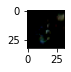

In [20]:
fake_images_np = a_o.upper.numpy()
fake_images_np = fake_images_np.reshape(fake_images_np.shape[0], 3, 32, 32)
fake_images_np = fake_images_np.transpose((0, 2, 3, 1))
R, C = 5, 5
for i in range(batch_size):
    plt.subplot(R, C, i + 1)
    plt.imshow(fake_images_np[i], interpolation='bilinear')
plt.show()

In [22]:
model_raw, ds_fetcher, is_imagenet = selector.select('cifar10')
# ds_val = ds_fetcher(batch_size=10, train=False, val=True)
# for idx, (data, target) in enumerate(ds_val):
#     data =  Variable(torch.FloatTensor(data))
#     output = model_raw(data)
#     print(D(data))
l = [module for module in model_raw.modules() if type(module) != nn.Sequential]
print(l)
model_raw.eval()
data = a_o.upper
output = model_raw(data)
list(output[0].cpu().detach().numpy()).index(max(output[0]))

Building and initializing cifar10 parameters
Sequential(
  (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (9): ReLU()
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (12): ReLU()
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), paddi

[CIFAR(
  (features): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1)

3

In [ ]:
C = model_raw
print(0)
tic = time.perf_counter()
b = Box_o(a_o.upper, a_o.lower, True)
b.conv2d(weight=C.state_dict()['features.0.weight'], c_out=128, kernel_size=3, stride=1, padding=1, bias=C.state_dict()['features.0.bias'])
print(0.1)
b.batchNorm2d(mean=C.state_dict()['features.1.running_mean'], var=C.state_dict()['features.1.running_var'], eps=1e-05, weight=None, bias=None)
print(0.2)
b.relu()

print(time.perf_counter()-tic)
print(1)
tic = time.perf_counter()

b.conv2d(weight=C.state_dict()['features.3.weight'], c_out=128, kernel_size=3, stride=1, padding=1, bias=C.state_dict()['features.3.bias'])
b.batchNorm2d(mean=C.state_dict()['features.4.running_mean'], var=C.state_dict()['features.4.running_var'], eps=1e-05, weight=None, bias=None)
b.relu()

print(time.perf_counter()-tic)
print(2)
tic = time.perf_counter()

b.maxpool2d(2)
b.conv2d(weight=C.state_dict()['features.7.weight'], c_out=256, kernel_size=3, stride=1, padding=1, bias=C.state_dict()['features.7.bias'])
b.batchNorm2d(mean=C.state_dict()['features.8.running_mean'], var=C.state_dict()['features.8.running_var'], eps=1e-05, weight=None, bias=None)
b.relu()

print(time.perf_counter()-tic)
print(3)
tic = time.perf_counter()

b.conv2d(weight=C.state_dict()['features.10.weight'], c_out=256, kernel_size=3, stride=1, padding=1, bias=C.state_dict()['features.10.bias'])
b.batchNorm2d(mean=C.state_dict()['features.11.running_mean'], var=C.state_dict()['features.11.running_var'], eps=1e-05, weight=None, bias=None)
b.relu()

print(time.perf_counter()-tic)
print(4)
tic = time.perf_counter()

b.maxpool2d(2)
b.conv2d(weight=C.state_dict()['features.14.weight'], c_out=512, kernel_size=3, stride=1, padding=1, bias=C.state_dict()['features.14.bias'])
b.batchNorm2d(mean=C.state_dict()['features.15.running_mean'], var=C.state_dict()['features.15.running_var'], eps=1e-05, weight=None, bias=None)
b.relu()

print(time.perf_counter()-tic)
print(5)
tic = time.perf_counter()

b.conv2d(weight=C.state_dict()['features.17.weight'], c_out=512, kernel_size=3, stride=1, padding=1, bias=C.state_dict()['features.17.bias'])
b.batchNorm2d(mean=C.state_dict()['features.18.running_mean'], var=C.state_dict()['features.18.running_var'], eps=1e-05, weight=None, bias=None)
b.relu()

print(time.perf_counter()-tic)
print(6)
tic = time.perf_counter()

b.maxpool2d(2)
b.conv2d(weight=C.state_dict()['features.21.weight'], c_out=1024, kernel_size=3, stride=1, padding=0, bias=C.state_dict()['features.21.bias'])
b.batchNorm2d(mean=C.state_dict()['features.22.running_mean'], var=C.state_dict()['features.22.running_var'], eps=1e-05, weight=None, bias=None)
b.relu()

print(time.perf_counter()-tic)
print(7)
tic = time.perf_counter()

b.maxpool2d(2)
b.linear(weight=C.state_dict()['classifier.0.weight'], bias=C.state_dict()['classifier.0.bias'])

print(time.perf_counter()-tic)
print(8)

print(list(b.upper).index(max(b.upper)), 'mine')
print(list(output[0]).index(max(output[0])), 'real')

[autoreload of lipprop_optimized failed: Traceback (most recent call last):
  File "/Users/ksarangmath/anaconda3/envs/eran/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/ksarangmath/anaconda3/envs/eran/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/Users/ksarangmath/anaconda3/envs/eran/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/Users/ksarangmath/anaconda3/envs/eran/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 674, in exec_module
  File "<frozen importlib._bootstrap_external>", line 781, in get_code
  File "<frozen importlib._bootstrap_external>", line 741, in source_to_code
  File "<frozen importlib._bootstrap>", 

0
0.1
0.2
12.44116138597019
1


In [10]:
# i=18
# j=30
# print(convW2[4*j:4*j+4,16*i:16+16*i])
# print(C.state_dict()['features.21.weight'][j][i])


In [94]:
iii = torch.randn(1,512,4,4)



In [116]:
C = model_raw
tic = time.perf_counter()

b = Box_o(iii, iii, True)

convW2 = b.conv2d(weight=C.state_dict()['features.21.weight'], c_out=1024, kernel_size=3, stride=1, padding=0, bias=C.state_dict()['features.21.bias'])
b.batchNorm2d(mean=C.state_dict()['features.22.running_mean'], var=C.state_dict()['features.22.running_var'], eps=1e-05, weight=None, bias=None)
b.relu()

print(time.perf_counter()-tic)
print(7)
tic = time.perf_counter()

b.maxpool2d(2)
b.linear(weight=C.state_dict()['classifier.0.weight'], bias=C.state_dict()['classifier.0.bias'])


lip = b.getLip()

print(time.perf_counter()-tic)
print(8)

6.93738559493795
7
0.18203699099831283
8


In [118]:
id = np.identity(100)*30
id[3,3]=50

print(np.linalg.norm(id,ord=2))
np.count_nonzero(lip[1])
np.product(lip[1].shape)
# print(np.sum(lip[1]-lip[2]))
lip[0]

50.0


437.4947

In [112]:
>>> m = nn.ConvTranspose2d(1, 1, 3, stride=1, bias=False)
>>> # non-square kernels and unequal stride and with padding
>>> input = torch.randn(1, 1, 3, 3)
>>> output = m(input)
input=input.numpy()
output

tensor([[[[ 0.4169, -0.6115, -0.0629,  0.4360, -0.1867],
          [ 0.1699,  0.0829, -0.4691,  0.0837,  0.3754],
          [-0.5965,  0.7514,  0.0433, -1.1748, -0.0266],
          [-0.3236,  0.3251,  0.7135,  0.0629, -0.3227],
          [-0.0399, -0.0022,  0.2679,  0.4698,  0.1570]]]],
       grad_fn=<SlowConvTranspose2DBackward>)

In [83]:
torch.manual_seed(0)
for i in range(5):
    torch.randn(1,100,1,1)+0.1

In [84]:
a=torch.randn(1,100,1,1)

In [203]:
import math

In [217]:
a = torch.randn(4096,8192)


In [247]:
upper = np.ones((4096,4096))
print(upper)

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


In [248]:
var = C.state_dict()['features.22.running_var'].numpy()
step = upper.shape[0]//len(var)
eps=1e-5
for i in range(len(var)):
    upper[i*step:i*step+step] *= 1/math.sqrt(var[i]+eps)

In [28]:
convW2[0:5,0:16]

array([[-0.0299, -0.1573, -0.0599,  0.    , -0.0523,  0.0366, -0.0046,
         0.    ,  0.0858, -0.0138,  0.0403,  0.    ,  0.    ,  0.    ,
         0.    ,  0.    ],
       [ 0.    , -0.0299, -0.1573, -0.0599,  0.    , -0.0523,  0.0366,
        -0.0046,  0.    ,  0.0858, -0.0138,  0.0403,  0.    ,  0.    ,
         0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    , -0.0299, -0.1573, -0.0599,
         0.    , -0.0523,  0.0366, -0.0046,  0.    ,  0.0858, -0.0138,
         0.0403,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    , -0.0299, -0.1573,
        -0.0599,  0.    , -0.0523,  0.0366, -0.0046,  0.    ,  0.0858,
        -0.0138,  0.0403],
       [-0.0569,  0.0309, -0.0848,  0.    ,  0.1172,  0.0266, -0.1015,
         0.    ,  0.035 , -0.1561, -0.0932,  0.    ,  0.    ,  0.    ,
         0.    ,  0.    ]], dtype=float32)

In [28]:
np.set_printoptions(4)

In [33]:
from scipy import sparse

In [37]:
s = sparse.csr_matrix(sparse.eye(5))

In [30]:
print(convW2.toarray())
print(convW2.count_nonzero())

[[-0.0299 -0.1573 -0.0599 ...  0.      0.      0.    ]
 [ 0.     -0.0299 -0.1573 ...  0.      0.      0.    ]
 [ 0.      0.      0.     ... -0.0776 -0.0888  0.    ]
 ...
 [ 0.     -0.0474  0.0154 ...  0.      0.      0.    ]
 [ 0.      0.      0.     ...  0.1143  0.0379  0.    ]
 [ 0.      0.      0.     ...  0.13    0.1143  0.0379]]
18874368


In [13]:
tem = np.zeros(10000,dtype=np.int32)
tem[[4,5,3,54,342,645,3234,534,3545,875]]=7
dat = np.vstack((np.nonzero(tem),np.nonzero(tem),tem[np.nonzero(tem)])).T
datt = np.vstack([dat,dat])
dat

array([[   3,    3,    7],
       [   4,    4,    7],
       [   5,    5,    7],
       [  54,   54,    7],
       [ 342,  342,    7],
       [ 534,  534,    7],
       [ 645,  645,    7],
       [ 875,  875,    7],
       [3234, 3234,    7],
       [3545, 3545,    7]])

In [45]:
sp = sparse.coo_matrix((dat[2],(dat[0],dat[1])),dtype=np.float32,shape=(10000,10000))

In [47]:
sp.toarray()[4][4]

7.0

In [48]:
ar = [[np.array([1,2])],[np.array([3,4]),np.array([3,4])]]

In [50]:
ar.T

AttributeError: 'list' object has no attribute 'T'

0.0

In [31]:
a = [3,4,5]
b = [5,6,6]
a.extend(b)

In [18]:
np.nonzero(tem)[0].dtype

dtype('int64')

In [8]:
amin = np.random.rand(2,2)*-1
amax = np.random.rand(2,2)
print(amin,amax)

[[-0.14842448 -0.6944333 ]
 [-0.57033579 -0.05205047]] [[0.10357181 0.00570077]
 [0.55918761 0.93485761]]


In [9]:

np.where(-amin > amax, amin, amax)

array([[-0.14842448, -0.6944333 ],
       [-0.57033579,  0.93485761]])

tensor([[[[ 3.5228,  1.9876,  1.6766,  4.1924],
          [ 2.5091,  1.9218,  2.7797,  2.0597],
          [ 1.4829, -0.3418,  0.8780,  1.8466],
          [ 2.2855, -0.3121,  1.9576,  2.8220]],

         [[ 0.7745,  1.3710,  1.8567,  2.3286],
          [ 1.8731,  1.3542,  0.5543,  2.5945],
          [ 2.5615,  1.8877,  1.3519,  1.4698],
          [ 1.6809, -0.2187,  2.3071,  2.8216]],

         [[ 1.5622,  2.3852,  3.1799,  2.3485],
          [ 1.0983,  2.9149,  2.4529,  1.6607],
          [ 2.1374,  1.1696,  3.5923,  1.8019],
          [ 2.0163,  1.3038,  1.8148, -0.6180]],

         ...,

         [[ 2.8361,  2.3777,  1.9634,  0.7622],
          [ 1.4321,  3.0271,  1.3039,  1.8503],
          [ 0.9815,  4.4549,  1.3696,  1.4349],
          [ 1.3524,  2.2074,  0.1652,  2.9107]],

         [[ 2.1471,  2.2217, -0.0359,  1.9756],
          [ 1.5435,  2.1295,  0.4581,  1.9453],
          [ 2.9850,  2.1370,  2.0553,  3.1757],
          [ 1.1225,  1.9675,  2.0867,  2.2552]],

         [[ 1.9

In [141]:
dum = np.array([-1,1,2,-3])
dum*(dum>0)
10**10

10000000000

In [124]:
np.linalg.norm(np.random.rand(10,3084)*100000000,ord=2)

8924132661.33773

In [131]:
iii=torch.randn(1,3,32,32)
C = model_raw

b = Box_o(iii+0.1, iii-0.1, True)
cl = np.copy(b.conv2d(weight=C.state_dict()['features.0.weight'], c_out=128, kernel_size=3, stride=1, padding=1, bias=C.state_dict()['features.0.bias']))

bl = np.copy(b.batchNorm2d(mean=C.state_dict()['features.1.running_mean'], var=C.state_dict()['features.1.running_var'], eps=1e-05, weight=None, bias=None))

b.relu()

conv
7.6857533
bn
60.97663
relu
51.37341


In [133]:
bl[0][0]
print(cl)
print(bl)

[[-0.24944614 -0.22445156  0.         ...  0.          0.
   0.        ]
 [-0.25780773 -0.24944614 -0.22445156 ...  0.          0.
   0.        ]
 [ 0.         -0.25780773 -0.24944614 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.07296999  0.27267373
   0.        ]
 [ 0.          0.          0.         ...  0.08814757  0.07296999
   0.27267373]
 [ 0.          0.          0.         ...  0.          0.08814757
   0.07296999]]
[[-0.63650775 -0.57272947  0.         ...  0.          0.
   0.        ]
 [-0.6578439  -0.63650775 -0.57272947 ...  0.          0.
   0.        ]
 [ 0.         -0.6578439  -0.63650775 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.2762808   1.0324041
   0.        ]
 [ 0.          0.          0.         ...  0.33374655  0.2762808
   1.0324041 ]
 [ 0.          0.          0.         ...  0.          0.33374655
   0.2762808 ]]


In [139]:
1/np.sqrt(C.state_dict()['features.1.running_var'][0]+.1e-05)

tensor(2.5518)

In [140]:
2.5518*-0.24944614

-0.636536660052

In [20]:
vec = torch.randn(100)
np.linalg.norm((vec+0.1)-(vec-0.1))

2.0000002